# Linear Regression and ElasticNet with sklearn

For this tutorial, let us use of the California Housing data set. 

It has 20640 observations on housing prices with 9 variables:

- Longitude: angular distance of a geographic place north or south of the earth’s equator for each block group
- Latitude: angular distance of a geographic place east or west of the earth’s equator for each block group;
- Housing median age: median age of the people that belong to a block group. 
- Total rooms: total number of rooms in the houses per block group;
- Total bedrooms: total number of bedrooms in the houses per block group;
- Population: the number of inhabitants of a block group;
- Households: units of houses and their occupants per block group;
- Median income: the median income of people that belong to a block group; 
- Median house value: the dependent variable and refers to the median house value per block group.

## Load Data

Download the data [from here](http://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html). Find the cal_housing.zip folder, download and untar it so that you can access the data folders.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Check out the Data

In [2]:
# Load in the data
df = pd.read_csv('CaliforniaHousing/cal_housing.data', sep=',', header=None)
df.head()

,0,1,2,3,4,5,6,7,8
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0


In [3]:
df.columns = ['longitude', 'latitude', \
              'housingMedianAge', 'totalRooms',\
              'totalBedrooms', 'population',\
              'households', 'medianIncome',\
              'medianHouseValue']

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
longitude           20640 non-null float64
latitude            20640 non-null float64
housingMedianAge    20640 non-null float64
totalRooms          20640 non-null float64
totalBedrooms       20640 non-null float64
population          20640 non-null float64
households          20640 non-null float64
medianIncome        20640 non-null float64
medianHouseValue    20640 non-null float64
dtypes: float64(9)
memory usage: 1.4 MB


In [5]:
df.describe()

,longitude,latitude,housingMedianAge,totalRooms,totalBedrooms,population,households,medianIncome,medianHouseValue
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.898014,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.247906,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,295.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


# EDA

Let's create some simple plots to check out the data!

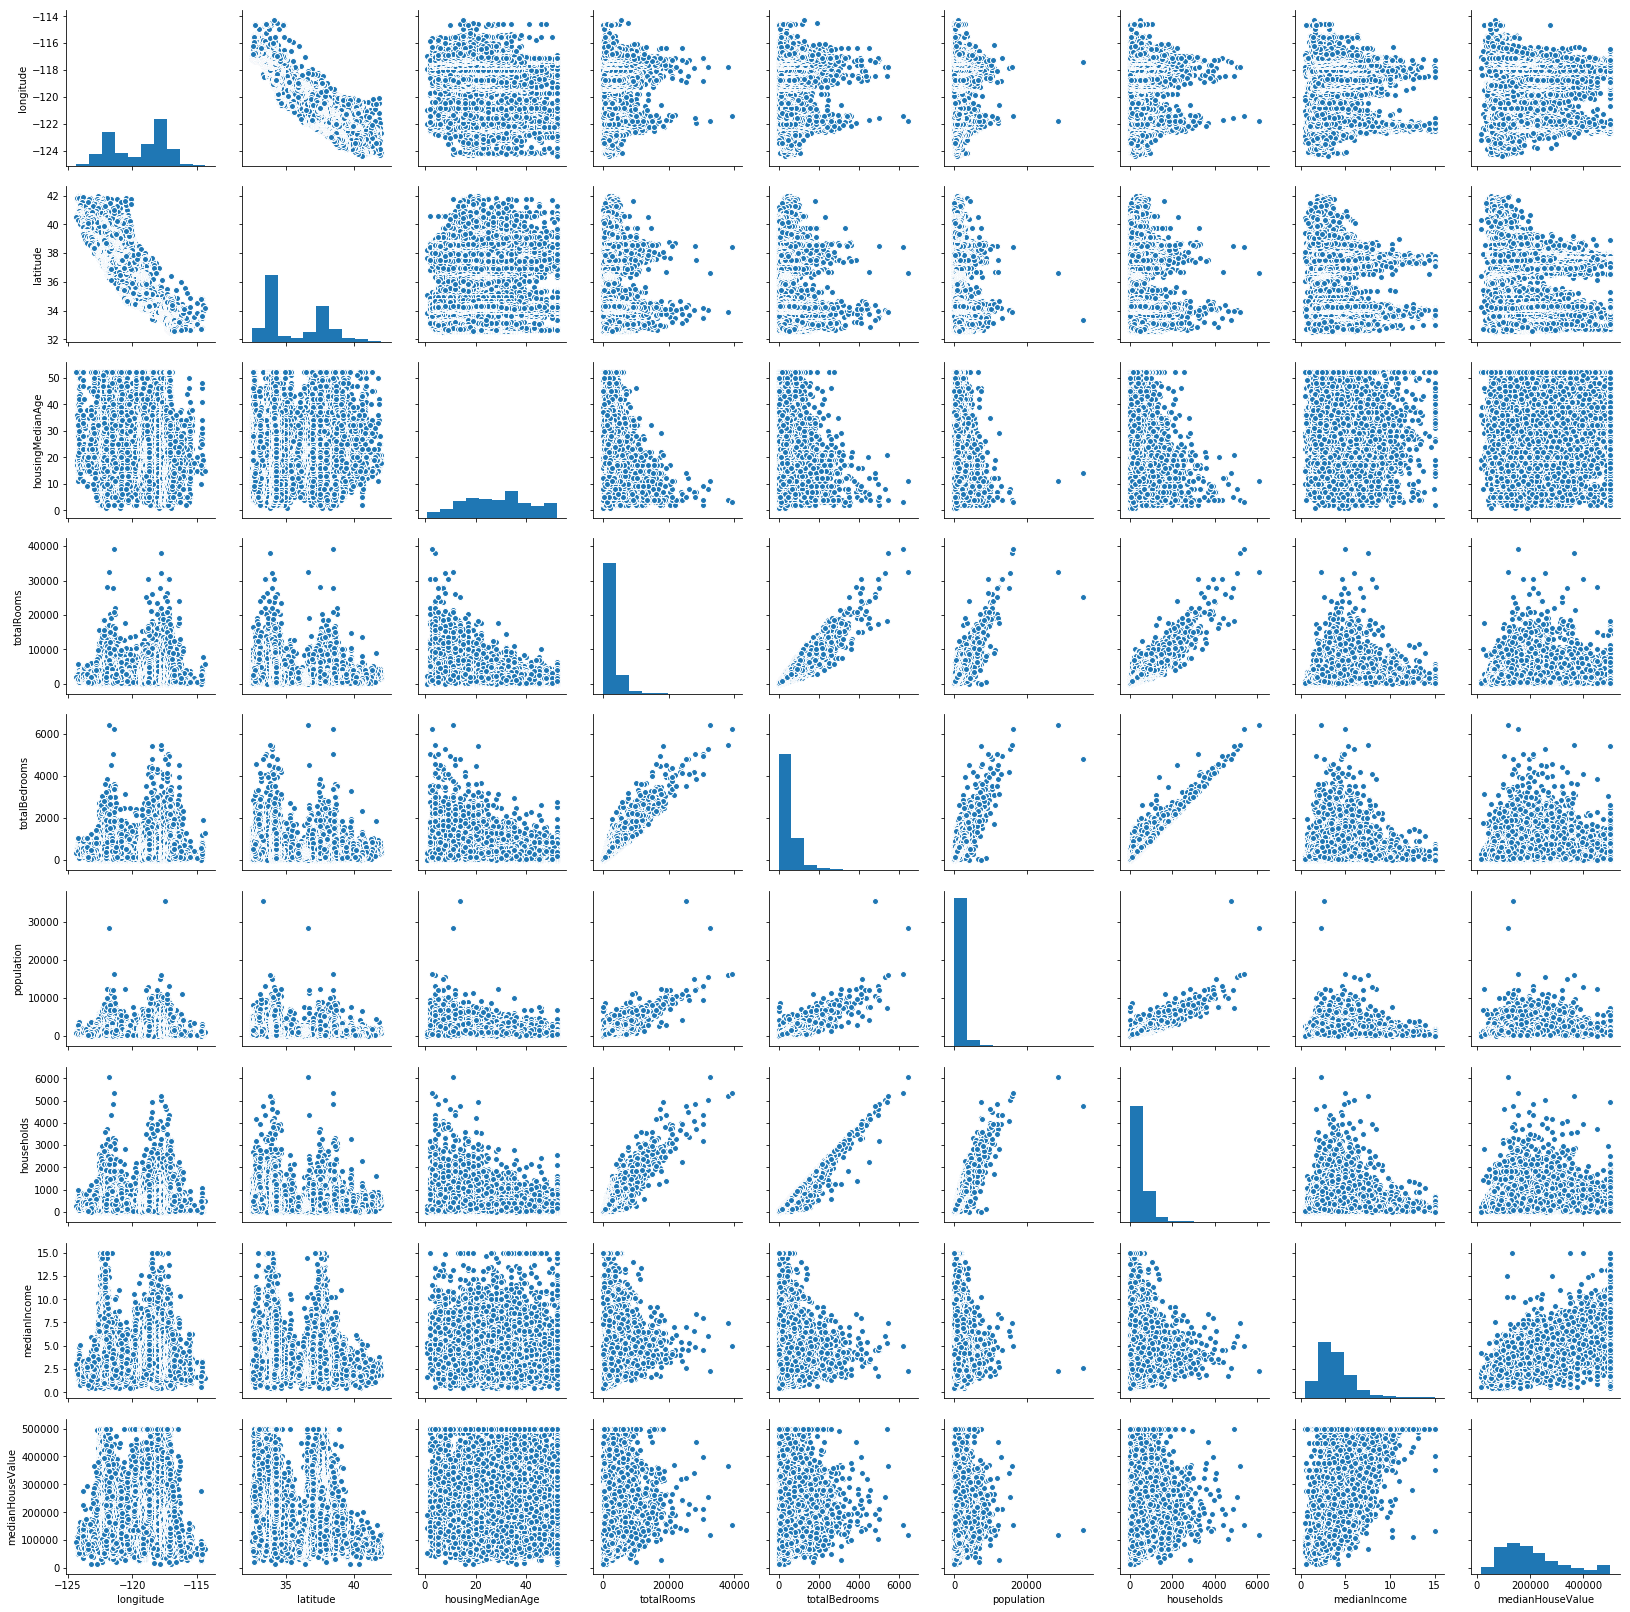

In [6]:
sns.pairplot(df)

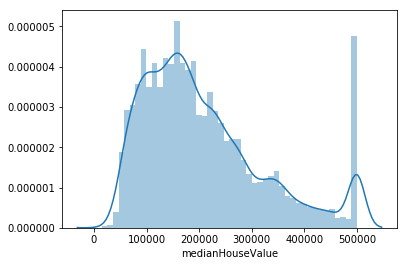

In [7]:
sns.distplot(df['medianHouseValue'])

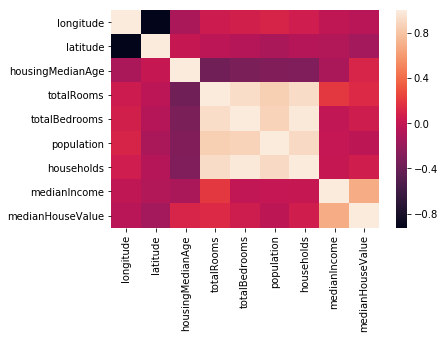

In [8]:
sns.heatmap(df.corr())

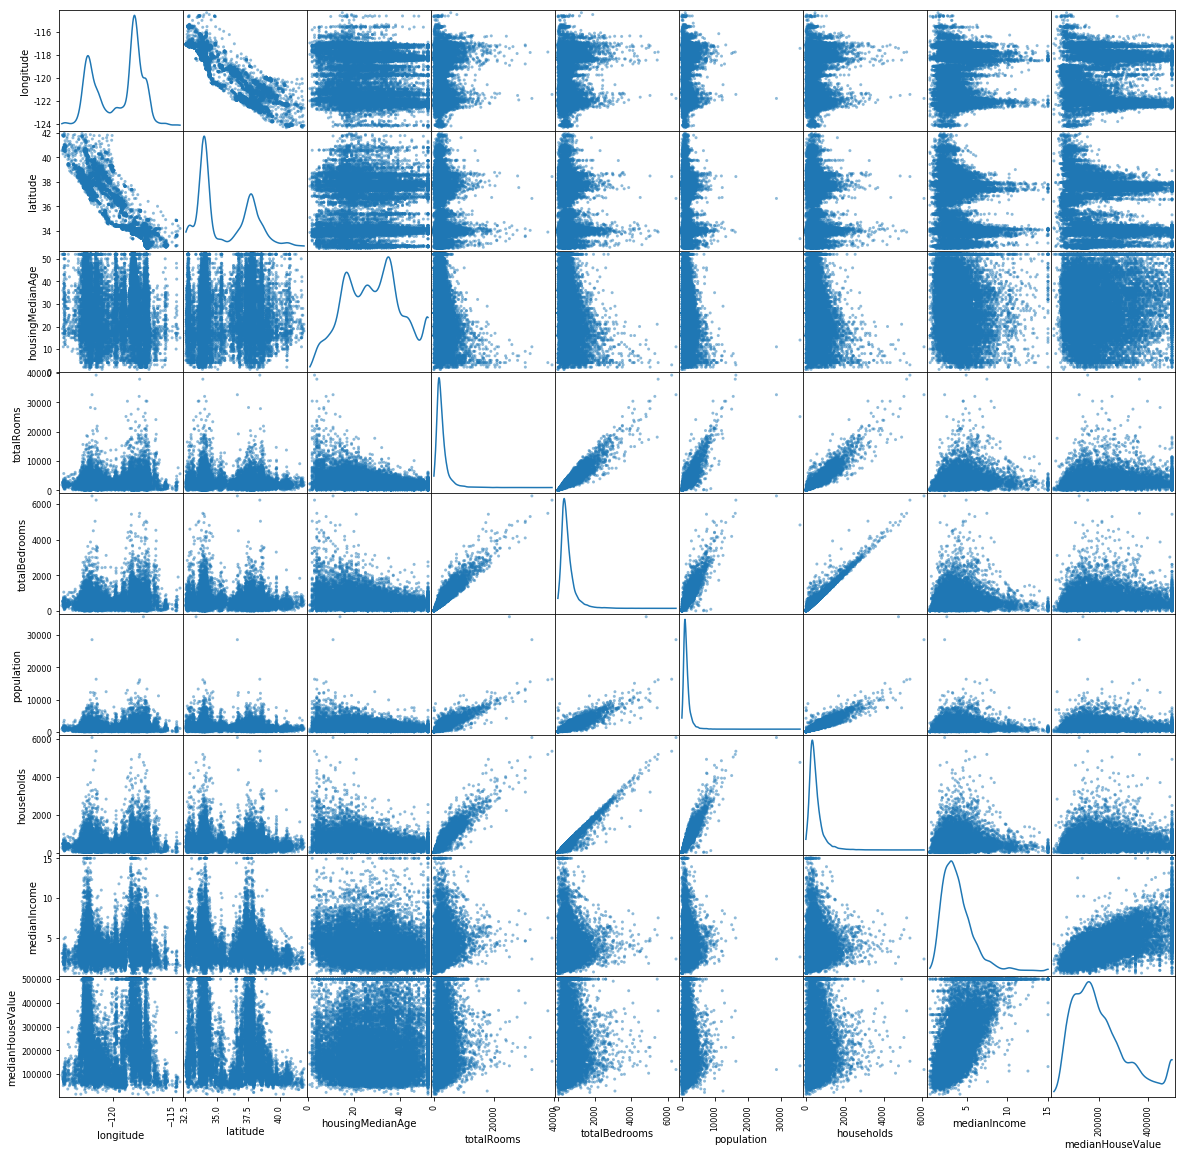

In [9]:
_ = pd.plotting.scatter_matrix(df, figsize=(20, 20), diagonal='kde')

## Preprocessing

target variable `meadianHouseValue` has quite big values, let's adjust it.
- express house values in units of 100,000. 

In [6]:
df['medianHouseValue']= df['medianHouseValue'].apply(lambda x:x/100000)

## Feature Engineering

add the following columns to the data set:

Rooms per household: the number of rooms in households per block group

Population per household: how many people live in households per block group

Bedrooms per room: how many rooms are bedrooms per block group;

In [7]:
df['roomsPerHousehold'] = df['totalRooms'].div(df['households'])
df['populationPerHousehold'] = df['population'].div(df['households'])
df['bedroomsPerRoom'] = df['totalBedrooms'].div(df['totalRooms'])

We will need to first split up our data into an X array that contains the features to train on, and a y array with the target variable, in this case the medianHouseValue column. We will toss out some of the columns. let’s leave out variables such as longitude, latitude, housingMedianAge and totalRooms.

In [8]:
select = ["medianHouseValue", 
              "totalBedrooms", 
              "population", 
              "households", 
              "medianIncome", 
              "roomsPerHousehold", 
              "populationPerHousehold", 
              "bedroomsPerRoom"]
df = df[select]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
medianHouseValue          20640 non-null float64
totalBedrooms             20640 non-null float64
population                20640 non-null float64
households                20640 non-null float64
medianIncome              20640 non-null float64
roomsPerHousehold         20640 non-null float64
populationPerHousehold    20640 non-null float64
bedroomsPerRoom           20640 non-null float64
dtypes: float64(8)
memory usage: 1.3 MB


In [9]:
#Features Dataset
X = df.drop(['medianHouseValue'], axis=1)

#Target Dataset
y = df['medianHouseValue']

min and max values of all the attributes are scattered over a wide range of values, so let us normalize the data.

In [10]:
from sklearn.preprocessing import StandardScaler
# scale all the features
X = StandardScaler(with_mean=False).fit_transform(X)

## Train Test Split

Now let's split the data into a training set and a testing set. We will train out model on the training set and then use the test set to evaluate the model.

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Creating and Training the Linear Regression Model

In [13]:
from sklearn.linear_model import LinearRegression

In [14]:
lm = LinearRegression()

In [15]:
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

## Model Evaluation

Let's evaluate the model by checking out it's coefficients and how we can interpret them.

In [16]:
# print the intercept
print(lm.intercept_)

-1.0080988658


In [17]:
coeff_df = pd.DataFrame(lm.coef_,df.columns[1:],columns=['Coefficient'])
coeff_df

,Coefficient
totalBedrooms,-0.189268
population,-0.479293
households,0.666512
medianIncome,0.966561
roomsPerHousehold,0.004146
populationPerHousehold,-0.000153
bedroomsPerRoom,0.291828


## Predictions from our Model

Let's grab predictions off our test set and see how well it did!

In [18]:
predictions = lm.predict(X_test)

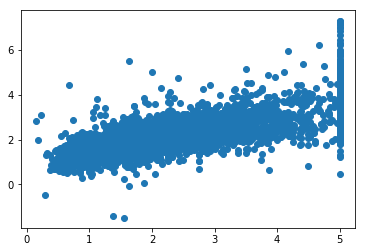

In [19]:
plt.scatter(y_test,predictions)

**Residual Histogram**

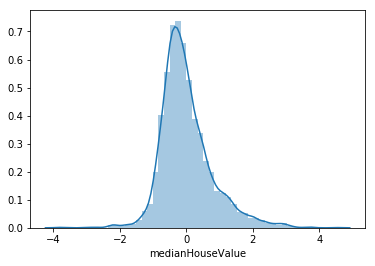

In [20]:
sns.distplot((y_test-predictions),bins=50);

## Regression Evaluation Metrics


Here are three common evaluation metrics for regression problems:

**Mean Absolute Error** (MAE) is the mean of the absolute value of the errors:

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

**Mean Squared Error** (MSE) is the mean of the squared errors:

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

**Root Mean Squared Error** (RMSE) is the square root of the mean of the squared errors:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

Comparing these metrics:

- **MAE** is the easiest to understand, because it's the average error.
- **MSE** is more popular than MAE, because MSE "punishes" larger errors, which tends to be useful in the real world.
- **RMSE** is even more popular than MSE, because RMSE is interpretable in the "y" units.

All of these are **loss functions**, because we want to minimize them.

In [21]:
from sklearn import metrics

In [22]:
print('EVS:', metrics.explained_variance_score(y_test, predictions))
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('R2:', metrics.r2_score(y_test, predictions))

EVS: 0.537245387714
MAE: 0.571743371933
MSE: 0.606412227846
RMSE: 0.778724744596
R2: 0.537234376508


## ElasticNet model

In [23]:
from sklearn.linear_model import ElasticNet
regr = ElasticNet(max_iter=1000, alpha=0.3, l1_ratio=0.8)
regr.fit(X_train,y_train)

ElasticNet(alpha=0.3, copy_X=True, fit_intercept=True, l1_ratio=0.8,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [24]:
print(regr.intercept_)
coeff_en = pd.DataFrame(regr.coef_,df.columns[1:],columns=['Coefficient'])
coeff_en

0.996770319697


,Coefficient
totalBedrooms,0.00000
population,-0.00000
households,0.00000
medianIncome,0.52634
roomsPerHousehold,0.00000
populationPerHousehold,-0.00000
bedroomsPerRoom,0.00000


In [25]:
from sklearn import metrics
print('EVS:', metrics.explained_variance_score(y_test, predictions))
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('R2:', metrics.r2_score(y_test, predictions))

EVS: 0.537245387714
MAE: 0.571743371933
MSE: 0.606412227846
RMSE: 0.778724744596
R2: 0.537234376508


The RMSE measures how much error there is between two datasets comparing a predicted value and an observed or known value. The smaller an RMSE value, the closer predicted and observed values are.

The R2 (“R squared”) or the coefficient of determination is a measure that shows how close the data are to the fitted regression line. This score will always be between 0 and a 100% (or 0 to 1 in this case), where 0% indicates that the model explains none of the variability of the response data around its mean, and 100% indicates the opposite: it explains all the variability. That means that, in general, the higher the R-squared, the better the model fits your data.

clearly, R2 is quite small indicating that model needs improvemnets.
We need to focus on feature engineering, but for now its good enough to learn about the implementation of LinearRegression and ElasticNet model of sklearn. Both models gave almost similar performance, but ofcourse with some optimization of ElasticNets parameters, we can gain in metrics.